# Volume 4: Image Processing
    Daniel Perkins
    MATH 439
    2/11/25

In [13]:
import numpy as np
from numpy.random import randint, uniform, randn
import matplotlib.pyplot as plt
from numpy.linalg import norm
from imageio.v3 import imread, imwrite

# Load Images

In [2]:
# Load in the image.
image = imread('balloons_color.jpg', mode='F') * 1./255

# Create the noisy image by altering pixels from the original image.
noisy_image = image.copy()
x, y = image.shape
for i in range(x*y//50):
	noisy_image[randint(x), randint(y)] = (127 + randint(127)) * 1./255

# Problem 1

Finish the following function that implements the anisotropic diffusion algorithm.
Use the padded array technique to deal with the edges of the image.

Run your function on the noisy image with $\sigma=.1$, $\lambda=.25$, $N=20$, and $g(x)=e^{-\left(\frac{x}{\sigma}\right)^2}$.
Display the original image, the noisy image, and the cleaned image.
Explain why anisotropic diffusion does not smooth out the noise.

In [36]:
def anis_diff(U, N, g, lambda_=0.25):
    """
    Run the Anisotropic Diffusion differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        g (callable): diffusion function.
        lambda_ (float): scaling coefficient.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    # Pad the ends
    Y = np.pad(U, mode="edge", pad_width=1)
    
    for i in range(N):
        # Equation 13.3
        first = np.roll(Y, 1, axis=0) - Y
        first = first * g(first)
        second = np.roll(Y, -1, axis=0) - Y
        second = second * g(second)
        third = np.roll(Y, 1, axis=1) - Y
        third = third * g(third)
        fourth = np.roll(Y, -1, axis=1) - Y
        fourth = fourth * g(fourth)
        
        # The rest of the equations
        Y = Y + lambda_*(first + second + third + fourth)
        
    return Y[1:-1, 1:-1]

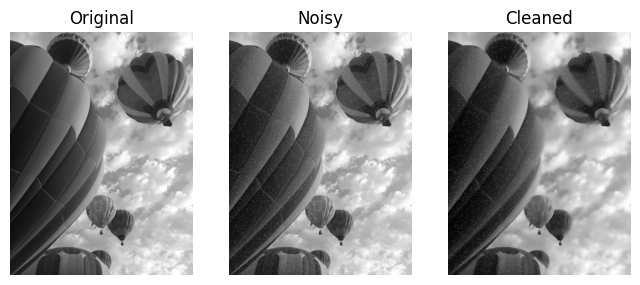

In [37]:
# Anisotropic Diffusion
N = 20
sigma = 0.1
def g(x): return np.exp(-(x/sigma)**2)
lambda_=0.25
cleaned_image = anis_diff(noisy_image, N, g, lambda_=lambda_)

# Plot it
plt.figure(figsize=(8, 4))
plt.subplot(131)
plt.axis("off")
plt.title("Original")
plt.imshow(image, cmap="gray")
plt.subplot(132)
plt.axis("off")
plt.title("Noisy")
plt.imshow(noisy_image, cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("Cleaned")
plt.imshow(cleaned_image, cmap="gray")
plt.show()

The anisotropic diffusion does not smooth out the noise because it over accounts for the edges. As it attempts to avoid just blurring out the edges, it also avoids smoothing out the noise. This is because the function $g$ is applied to everything. A better method should be used to weight the effects of both edges and noise.

Another reason for this is that many of the boundaries hae similar shades. So, the noise around them can't be removed.

# Problem 2

Finish the following function that implements the mimimum-biased finite difference scheme.
Run your function on the noisy image with $\lambda=0.25$.
Experiment with the number of iterations until the resulting image looks close to the original image.
Display the original image, the noisy image, and the cleaned image.

In [45]:
def min_bias(U, N, lambda_=0.25):
    """
    Run the Minimum Bias differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    # Pad the ends
    Y = np.pad(U, mode="edge", pad_width=1)
    
    # Define G
    first = np.abs(np.roll(Y, 1, axis=0) - Y)
    second = np.abs(np.roll(Y, -1, axis=0) - Y)
    third = np.abs(np.roll(Y, 1, axis=1) - Y)
    fourth = np.abs(np.roll(Y, -1, axis=1) - Y)
    
    G = np.stack([first, second, third, fourth], axis=0)
    G = np.partition(G, 2, axis=0)[:2]  # Take min two values
    G = np.mean(G, axis=0)  # Take mean of those two values
    
    for i in range(N):
        # Equation 13.3
        first = np.roll(Y, 1, axis=0) - Y
        first = first * G
        second = np.roll(Y, -1, axis=0) - Y
        second = second * G
        third = np.roll(Y, 1, axis=1) - Y
        third = third * G
        fourth = np.roll(Y, -1, axis=1) - Y
        fourth = fourth * G
        
        # The rest of the equations
        Y = Y + lambda_*(first + second + third + fourth)
        
    return Y[1:-1, 1:-1]

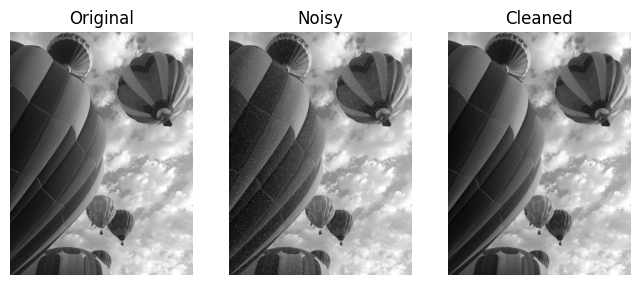

In [46]:
# Anisotropic Diffusion
N = 20
sigma = 0.1
lambda_=0.25
cleaned_image2 = min_bias(noisy_image, N, lambda_=lambda_)

# Plot it
plt.figure(figsize=(8, 4))
plt.subplot(131)
plt.axis("off")
plt.title("Original")
plt.imshow(image, cmap="gray")
plt.subplot(132)
plt.axis("off")
plt.title("Noisy")
plt.imshow(noisy_image, cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("Cleaned")
plt.imshow(cleaned_image2, cmap="gray")
plt.show()

# Problem 3

Finish the following function that implements the gradient descent finite diffrerence scheme.
Run your function on the noisy image with $\Delta t =$ 1e-3, $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$.
Experiment with the number of iterations until the noise is hard to see.
Display the original image, the noisy image, and the cleaned image.

In [15]:
def grad_desc(U, N, lambda_, delta_t, delta_x=1, delta_y=1):
    """
    Run the Gradient Descent differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        delta_t (float): change in time.
        delta_x (float): change in x.
        delta_y (float): change in y.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    # Rename variable to match previous lab
    imagename = "balloons_color.jpg"
    IM = U    
    IM_x, IM_y = IM.shape
    lam = lambda_
    num_time_steps = N

    # Set up initial data
    u = np.empty((2, IM_x, IM_y))
    u[0], u[1] = IM, IM
    initial_images = u.copy()

    # Define right hand side of the differential equation
    def rhs(u):
        # Approximate the second derivatives
        u_xx = np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)
        u_yy = np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)
        u[1:-1, 1:-1] -= delta_t*(u[1:-1, 1:-1] - IM[1:-1, 1:-1] - lam*(u_xx[1:-1, 1:-1] + u_yy[1:-1, 1:-1]))
        return u

    # Time step until successive iterations are close
    iteration = 0
    while iteration < num_time_steps:
        u[1] = rhs(u[1])
        if norm(np.abs((u[0]-u[1]))) < 1e-5: break
        u[0] = u[1]
        iteration += 1
        
    old = u.copy()  # Store it (for the next problem)
        
    # Store smoothed image
    imwrite("smoothed_" + imagename, (u[1] * 255).astype(np.uint8))
    return u[1]


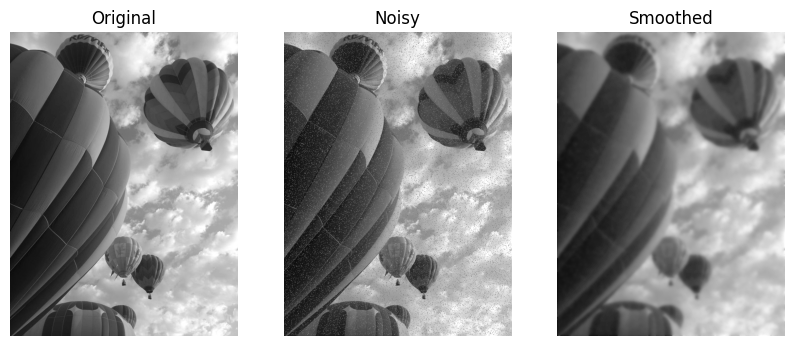

In [18]:
# Load in image
imagename = "balloons_color.jpg"
changed_pixels=40000
IM = imread(imagename, mode='F') * (1./255)
IM_original = np.copy(IM)
IM_x, IM_y = IM.shape

# Add noise
for lost in range(changed_pixels):
    x_, y_ = randint(1, IM_x-2), randint(1, IM_y-2)
    val = .1*randn() + .5
    IM[x_, y_] = max(min(val, 1.), 0.)

imwrite("noised_" + imagename, (IM * 255).astype(np.uint8))

delta_t = 1e-3
lam = 40
delta_x = 1
delta_y = 1
num_time_steps = 250
smoothed_image = grad_desc(IM, num_time_steps, lam, delta_t, delta_x=delta_x, delta_y=delta_y)

# Plot it
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.axis("off")
plt.title("Original")
plt.imshow(IM_original, cmap="gray")
plt.subplot(132)
plt.axis("off")
plt.title("Noisy")
plt.imshow(IM, cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("Smoothed")
plt.imshow(smoothed_image, cmap="gray")
plt.show()

# Problem 4

Derive the update scheme for the total variations method.
Then, finish the following function that implements this method.
Use a centered difference to approximate the values for $u_{x}$ and $u_{y}$.
Run your function on the noisy image using $\Delta t =$ 1e-3, $\lambda = 1, \epsilon =$ 1e-6, $\Delta x = 1,$ and $ \Delta y = 1$.
Experiment with the number of iterations until the resulting image looks close to the original image.
Display the original image, the noisy image, and the cleaned image.

In [19]:
def total_var(U, N, lambda_, epsilon, delta_t, delta_x=1, delta_y=1):
    """
    Run the Total Variations differencing scheme on an image.
    
    Parameters:
        U ((m,n) ndarray): grayscale image.
        N (int): number of iterations.
        lambda_ (float): scaling coefficient.
        epsilon (float): adjustment for denominator.
        delta_t (float): change in time.
        delta_x (float): change in x.
        delta_y (float): change in y.
        
    Returns:
        ((m,n) ndarray): the processed grayscale image.
    """
    # Rename variable to match previous lab
    imagename = "balloons_color.jpg"
    IM = U    
    IM_x, IM_y = IM.shape
    lam = lambda_
    num_time_steps = N
    eps = epsilon
    
    # Set up initial data
    u = np.empty((2, IM_x, IM_y))
    u[0], u[1] = IM, IM
    f = IM.copy()

    # Define right hand side of the differential equation
    def rhs(u):
        # Approximate the first derivatives
        u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1))/2
        u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0))/2
        
        # Approximate the second derivatives
        u_xx = np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)
        u_yy = np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)
        u_xy = (np.roll(u_x, -1, axis=0) - np.roll(u_x, 1, axis=0))/2
        
        # Equation 18.11
        numerator = u_xx*u_y**2 + u_yy*u_x**2 - 2*u_x*u_y*u_xy
        denominator = (eps + u_x**2 + u_y**2)**(3/2)
        right = -lam*(u-f) + numerator / denominator
        u += delta_t*right
        return u

    # Time step until successive iterations are close
    iteration = 0
    while iteration < num_time_steps:
        u[1] = rhs(u[1])
        if norm(np.abs((u[0]-u[1]))) < 1e-5: break
        # print(norm(np.abs((u[0]-u[1]))))
        u[0] = u[1]
        iteration += 1
        
    # Store smoothed image
    imwrite("smoothed2_" + imagename, (u[1] * 255).astype(np.uint8))
    
    return u[1]

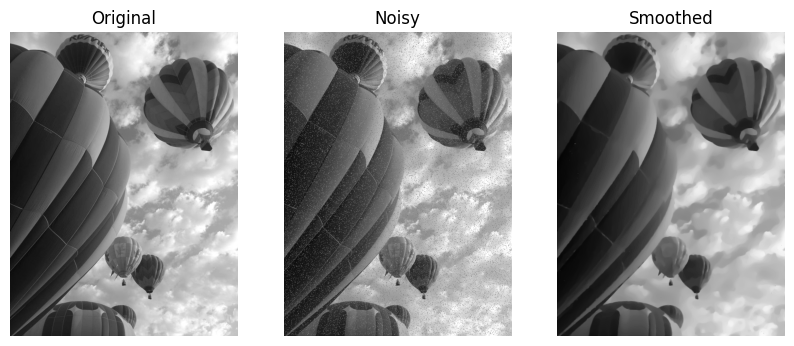

In [20]:
# Define variables and call function
delta_t = 1e-3
lam = 1
delta_x = 1
delta_y = 1
num_time_steps = 200
eps = 1e-6
smoothed_image2 = total_var(IM, num_time_steps, lam, eps, delta_t, delta_x=1, delta_y=1)

# Plot it
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.axis("off")
plt.title("Original")
plt.imshow(IM_original, cmap="gray")
plt.subplot(132)
plt.axis("off")
plt.title("Noisy")
plt.imshow(IM, cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("Smoothed")
plt.imshow(smoothed_image2, cmap="gray")
plt.show()